In [1]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp, potential_temp
from isca_tools.convection.base import convection_neutral_profile, lcl_temp_bolton, lcl_sigma_bolton_simple
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils.base import weighted_RMS, insert_to_array
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure, \
    get_var_at_plev, get_ds_in_pressure_range
from isca_tools.thesis.lapse_integral_simple import get_temp_2_layer_approx, fitting_2_layer_xr
from isca_tools.thesis.mod_parcel_theory import get_scale_factor_theory_numerical, get_temp_mod_parcel
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.thesis.adiabat_theory2 import get_temp_adiabat_surf, get_temp_adiabat
from isca_tools.thesis.profile_fitting import get_mse_env, get_tropopause_lev_ind, get_mse_prof_rms
from isca_tools.utils.ds_slicing import lat_lon_coord_slice
from isca_tools.thesis.adiabat_theory import get_theory_prefactor_terms
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple, Optional
import os
from sklearn.decomposition import PCA

from isca_tools.utils.xarray import flatten_to_numpy, unflatten_from_numpy, convert_ds_dtypes
from isca_tools.papers.byrne_2021 import get_quant_ind

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

In [3]:
def get_P(ds):
    return ds.PS * ds.hybm

In [4]:
load_from_file = True
if load_from_file:
    from jobs.theory_lapse.isca.thesis_figs.load_ds_quant import get_ds_out_path


    def amend_sample_dim(ds_list, n_sample_max_range=2):
        # Hack so all ds_list values have same number of samples, should only differ by one or two (less than n_sample_max_range)
        n_ds = len(ds_list)
        n_sample = [ds_list[i].sample.size for i in range(n_ds)]
        if np.max(n_sample) - np.min(n_sample) > n_sample_max_range:
            raise ValueError(f"n_sample={n_sample} has too wide a range of values")
        n_sample = np.min(n_sample)
        ds_list = [ds_list[i].isel(sample=slice(0, n_sample)) for i in range(n_ds)]
        return ds_list


    surf = ['aquaplanet', 'land']
    kappa_names = ['k=1', 'k=1_5']
    hemisphere = ['south', 'north']
    n_exp = len(kappa_names)
    ds_quant = {}
    for key in surf:
        ds_quant[key] = [0, 0]  # initialize as empty list
        for i in range(n_exp):
            # Load both hemispheres and combine into single ds_quant
            ds_quant[key][i] = [
                xr.open_dataset(get_ds_out_path(kappa_names[i], surf=key, hemisphere=hemisphere[j])).isel(surf=0)
                for j in range(len(hemisphere))]
            ds_quant[key][i] = amend_sample_dim(ds_quant[key][i])
            ds_quant[key][i] = xr.concat(ds_quant[key][i], dim='lat')

        ds_quant[key] = amend_sample_dim(ds_quant[key])
        # print('Selecting subsection of quant')
        # ds_quant[key] = [ds_quant[key][i].sel(quant=[1, 50, 99]) for i in range(n_exp)]
        ds_quant[key] = xr.concat(ds_quant[key], dim="tau_lw")
        ds_quant[key]['hybm'] = ds_quant[key].hybm.isel(quant=0, tau_lw=0, lat=0, sample=0)
        ds_quant[key]['rh_REFHT'] = ds_quant[key]['QREFHT'] / sphum_sat(ds_quant[key].TREFHT, ds_quant[key].PREFHT)
        ds_quant[key]['ZREFHT'] = ds_quant[key].Z3.isel(lev=-1)
        ds_quant[key]['mse_REFHT'] = moist_static_energy(ds_quant[key].TREFHT, ds_quant[key].QREFHT,
                                                         ds_quant[key].ZREFHT)
        ds_quant[key]['Z_ft_env'] = get_var_at_plev(ds_quant[key].Z3, get_P(ds_quant[key]), ds_quant[key].p_ft)
        ds_quant[key]['mse_ft_sat_env'] = moist_static_energy(ds_quant[key].T_ft_env,
                                                              sphum_sat(ds_quant[key].T_ft_env, ds_quant[key].p_ft),
                                                              ds_quant[key].Z_ft_env)
        for key2 in ds_quant[key]:
            if 'mod_parcel' in key2:
                ds_quant[key] = ds_quant[key].rename_vars({key2: key2.replace('mod_parcel', 'modParc')})

## Load Data
Don't need to do if load from file above.

Once compute the parcel temperature at $p_{FT}$, I save the dataset as takes around 8 minutes to compute.

In [5]:
# Info for loading in data
if not load_from_file:
    exp_dir = {'aquaplanet': 'tau_sweep/aquaplanet/depth=1/',
               'land': 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'}
    kappa_names = ['k=1', 'k=1_5']
    # kappa_names = ['k=1_2m']
    # kappa_names = ['k=1_5_2m']
    n_kappa = len(kappa_names)

    region = 'tropics'
    hemisphere = 'north'
    season = 'summer'
    lat_min = 0
    lat_max = 20
    lat_max = 4

    if hemisphere == 'north':
        lat_min = np.abs(lat_min)
        lat_max = np.abs(lat_max)
    else:
        lat_min = -np.abs(lat_max)
        lat_max = -np.abs(lat_min)

    season_months = {'summer': {'tropics': {'north': [5, 6, 7, 8, 9, 10],
                                            'south': [11, 12, 1, 2, 3, 4]},
                                'not_tropics': {'north': [6, 7, 8],
                                                'south': [12, 1, 2]}},
                     'winter': {}}
    for key in ['tropics', 'not_tropics']:
        season_months['winter'][key] = {'north': season_months['summer'][key]['south'],
                                        'south': season_months['summer'][key]['north']}

    # Load dataset - one at surface and one in free troposphere
    var_keep = ['temp', 'sphum', 'height', 'cape',
                'ps']  # only keep variables required to compute relative humidity and MSE
    use_time_start = 360 * 2
else:
    exp_dir = ast.literal_eval(ds_quant['aquaplanet'].exp_dir) | ast.literal_eval(ds_quant['land'].exp_dir)

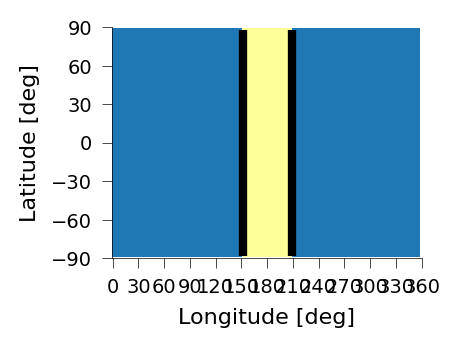

In [6]:
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir['land'],
                              kappa_names[0].replace('_2m', ''), 'land.nc')

fig, ax = plt.subplots(1, 1)
fig_resize(fig, 2)
isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]  # get the longitude coordinates of land

### Convert ds to CESM like data
Below I convert the variable names in the dataset into those expected from CESM.

In [7]:
if not load_from_file:
    ds = {key: [] for key in exp_dir}
    albedo = {key: [] for key in exp_dir}
    tau_sw = {key: [] for key in exp_dir}
    tau_lw = {key: [] for key in exp_dir}
    with tqdm(total=n_kappa * 2, position=0, leave=True) as pbar:
        for key in exp_dir:
            for j in range(n_kappa):
                ds_use = isca_tools.load_dataset(exp_dir[key] + kappa_names[j]).sel(time=slice(use_time_start, np.inf))[
                    var_keep]
                ds_use['sphum'] = ds_use.sphum.isel(pfull=-1)  # only keep surface SPHUM

                ds_use = ds_use.sel(lat=slice(lat_min, lat_max))
                # Only keep land longitudes - for aquaplanet, does not matter which we keep
                ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])

                # Only load in months of interest for season and hemisphere
                ds_use = isca_tools.utils.annual_time_slice(ds_use, season_months[season][region][hemisphere])
                # Stack longitude and time into new sample dimension to match CESM
                # ds_use = ds_use.stack(sample=("lon", "time"), create_index=False).chunk(dict(sample=-1))
                ds[key] += [ds_use.load()]

                namelist = isca_tools.load_namelist(exp_dir[key] + kappa_names[j])  # Need this for albedo_value
                albedo[key] += [namelist['mixed_layer_nml']['albedo_value']]
                tau_sw[key] += [namelist['two_stream_gray_rad_nml']['atm_abs']]
                tau_lw[key] += [namelist['two_stream_gray_rad_nml']['odp']]
                pbar.update(1)
            ds[key] = xr.concat(ds[key], dim=xr.DataArray(tau_lw[key], dims="tau_lw", name='tau_lw'))

    # Concatenate ds along surf dimension
    ds = xr.concat([ds[key] for key in ds],
                   dim=xr.DataArray([key for key in ds], dims="surf", name='surf'))

    # Rename variables to match CESM
    ds = ds.rename({'temp': 'T', 'sphum': 'QREFHT',
                    'height': 'Z3', 'cape': 'CAPE', 'ps': 'PS',
                    'pfull': 'lev'})

    # sigma_half reflects ds_us.pfull (starts with 0 - space, ends with 1 - surface)
    sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
    # hybm are sigma full levels
    hybm = np.convolve(sigma_levels_half, np.ones(2) / 2,
                       'valid')  # sigma levels corresponding to pressure levels
    ds['hybm'] = ds.lev * 0 + hybm  # convert to xarray

    # choose lowest model level as REFHT
    ds['TREFHT'] = ds.T.isel(lev=-1)
    ds['ZREFHT'] = ds.Z3.isel(lev=-1)
    ds['PREFHT'] = ds.PS * ds.hybm.isel(lev=-1)

### Compute variables for lapse fitting
Below, I compute the LCL and FT variables required to do the vertical temperature profile fitting.

In [8]:
if not load_from_file:
    temp_lcl_bolton_use = float(np.ceil(ds.TREFHT.median()))

    ds['mse_REFHT'] = moist_static_energy(ds.TREFHT, ds.QREFHT, ds.ZREFHT)
    ds['rh_REFHT'] = ds.QREFHT / sphum_sat(ds.TREFHT, ds.PREFHT)
    ds['p_lcl'] = lcl_sigma_bolton_simple(ds.rh_REFHT, temp_lcl_bolton_use) * ds.PREFHT
    # ds['T_lcl_parcel'] =
    ds['T_lcl_env'] = get_var_at_plev(ds.T, get_P(ds), ds.p_lcl)
    # ds['mse_env'] = get_mse_env(ds.T, ds.P, ds.Z3, ds.p_lcl, sphum_below_lcl=ds.QREFHT)
    p_ft = 500 * 100
    ds['T_ft_env'] = get_var_at_plev(ds.T, get_P(ds), p_ft)
    ds['Z_ft_env'] = get_var_at_plev(ds.Z3, get_P(ds), p_ft)
    ds['mse_ft_sat_env'] = moist_static_energy(ds.T_ft_env, sphum_sat(ds.T_ft_env, p_ft), ds.Z_ft_env)
else:
    temp_lcl_bolton_use = ds_quant['aquaplanet'].temp_surf_lcl_calc
    p_ft = ds_quant['aquaplanet'].p_ft

## Analysis as function of temperature quantile, $x$
Next, for a range of `TREFHT` quantiles, I first get the `ds` conditioned on these temperatures.

Then I compute the parameters and error for the `const` and `mod_parcel` lapse rate profiles on these sample days.

In [9]:
def get_ds_quant_single_coord(ds, quant=90, range_below=0.5, range_above=0.5):
    quant_mask = get_quant_ind(ds.TREFHT.squeeze(), quant, range_below, range_above, av_dim=['lon', 'time'],
                               return_mask=True)
    ds_use = ds.where(quant_mask).stack(sample=("lon", "time"), create_index=False).chunk(dict(sample=-1))
    ds_use = ds_use.load()
    ds_use = ds_use.where(ds_use.TREFHT > 0, drop=True)
    return ds_use


def get_ds_quant(ds, quant=90, range_below=0.5, range_above=0.5, n_keep=None):
    quant_mask = get_quant_ind(ds.TREFHT, quant, range_below, range_above, av_dim=['lon', 'time'], return_mask=True)
    # n_keep is so can concat ds of different quantiles. A given quant range will give slightly different numbers of samples at each location.
    # Through providing n_keep, you can ensure the number is always the same.
    n_keep_max = int(quant_mask.sum(dim=['lon', 'time']).min())
    if n_keep is None:
        n_keep = n_keep_max
    if n_keep > n_keep_max:
        raise ValueError(f'n_keep={n_keep} > n_keep_max={n_keep_max}')
    ds_out = []
    for i in range(ds.tau_lw.size):
        ds_use_j = []
        for j in range(ds.surf.size):
            ds_use_k = []
            for k in range(ds.lat.size):
                ds_use_k.append(
                    get_ds_quant_single_coord(ds.isel(tau_lw=i, surf=j, lat=k, drop=True), quant, range_below,
                                              range_above).isel(sample=slice(0, n_keep)))
            ds_use_k = xr.concat(ds_use_k, dim=ds.lat)
            ds_use_j.append(ds_use_k)
        ds_use_j = xr.concat(ds_use_j, dim=ds.surf)
        ds_out.append(ds_use_j)
    ds_out = xr.concat(ds_out, dim=ds.tau_lw)
    return ds_out

In [10]:
if not load_from_file:
    quant_range = 0.5
    n_sample = 180
    # n_sample = 10
    quant_all = np.arange(1, 100, 7)
    ds_quant = []
    for i in tqdm(quant_all):
        ds_quant.append(get_ds_quant(ds, i, quant_range, quant_range, n_sample))
    ds_quant = xr.concat(ds_quant, dim=xr.DataArray(quant_all, dims="quant", name='quant'))

In [11]:
def get_lapse_fitting_info(ds):
    ds.attrs['n_lev_above_integral'] = 3
    var_names = ['lapse', 'integral', 'error']

    with tqdm(total=2, position=0, leave=True) as pbar:
        for key in ['const', 'mod_parcel']:
            var = fitting_2_layer_xr(ds.T, get_P(ds), ds.TREFHT, ds.PREFHT, ds.rh_REFHT, ds.T_ft_env,
                                     p_ft, n_lev_above_upper2_integral=ds.n_lev_above_integral,
                                     method_layer2=key, temp_surf_lcl_calc=temp_lcl_bolton_use)
            # Must include fillna as inf to deal with all nan slice.
            for k, key2 in enumerate(var_names):
                ds[f'{key}1_{key2}'] = var[k]
            pbar.update(1)
    return ds

In [12]:
if not load_from_file:
    ds_quant = get_lapse_fitting_info(ds_quant)

### Scale Factor Computation
Below I plot the results of a numerical scaling factor computation with the new lapse rate contributions.

I only do this if I load the data within the notebook, as not really the point of this notebook, more interested in $\epsilon$.

In [13]:
if not load_from_file:
    ds_sf = ds_quant[['TREFHT', 'PREFHT', 'rh_REFHT', 'T_ft_env', 'mod_parcel1_lapse']].isel(surf=0, lat=0).mean(
        dim='sample')
    ds_sf['lapse_mod_D'] = ds_sf['mod_parcel1_lapse'].isel(layer=0) / 1000 - lapse_dry
    ds_sf['lapse_mod_M'] = ds_sf['mod_parcel1_lapse'].isel(layer=1) / 1000
    ds_sf = ds_sf.drop_vars('mod_parcel1_lapse')
    ds_sf = ds_sf.transpose('tau_lw', 'quant')
    ds_sf = ds_sf.rename({'TREFHT': 'temp_surf', 'PREFHT': 'p_surf', 'rh_REFHT': 'rh_surf', 'T_ft_env': 'temp_ft',
                          'tau_lw': 'co2'})
    for key in ['temp_surf', 'p_surf', 'rh_surf', 'lapse_mod_D', 'lapse_mod_M']:
        ds_sf[key + '_ref'] = ds_sf[key].median(dim='quant')
        if 'lapse' in key:
            ds_sf[key + '_ref'] = np.abs(ds_sf[key + '_ref'] * 0)  # for lapse, ref value is 0
        elif key != 'temp_surf':
            # For rh and pressure, keep at colder climate ref
            ds_sf[key + '_ref'] = ds_sf[key + '_ref'] * 0 + ds_sf[key + '_ref'].isel(co2=0)

In [14]:
def apply_scale_factor(ds, p_ft=p_ft):
    """Apply get_scale_factor_theory_numerical to an xarray.Dataset."""

    out_main, out_linear, out_dict = xr.apply_ufunc(
        get_scale_factor_theory_numerical,
        ds["temp_surf_ref"],  # (co2)
        ds["temp_surf"],  # (co2, quant)
        ds["rh_surf_ref"],  # (co2)
        ds["rh_surf"],  # (co2, quant)
        ds["temp_ft"],  # (co2, quant)
        ds["lapse_mod_D"],  # (co2, quant)
        ds["lapse_mod_M"],  # (co2, quant)
        p_ft,  # (co2) or scalar
        ds["p_surf_ref"],  # (co2) or scalar
        ds["p_surf"],  # (co2, quant) or None
        ds["lapse_mod_D_ref"],  # (co2) or None
        ds["lapse_mod_M_ref"],  # (co2) or None
        kwargs=dict(
            temp_surf_lcl_calc=300
        ),
        input_core_dims=[
            ["co2"],  # temp_surf_ref
            ["co2", "quant"],
            ["co2"],
            ["co2", "quant"],
            ["co2", "quant"],
            ["co2", "quant"],
            ["co2", "quant"],
            [],  # p_ft_ref
            ["co2"],  # p_surf_ref
            ["co2", "quant"],
            ["co2"],
            ["co2"],
        ],
        output_core_dims=[
            ["quant"],  # result array
            ["quant"],
            []  # dict-of-arrays (broadcast to co2)
        ],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float, object],
    )

    # Expand the dictionary output entries into proper DataArrays
    dict_ds = {'scale_factor': (ds['temp_surf'].isel(co2=1) - ds['temp_surf'].isel(co2=0)
                                ) / (ds['temp_surf_ref'].isel(co2=1) - ds['temp_surf_ref'].isel(co2=0))}
    for key in out_dict.item().keys():
        dict_ds[key] = xr.DataArray(
            out_dict.item()[key],
            coords=dict(quant=ds.quant),
            dims=("quant"),
        )
    return xr.Dataset({"scale_factor_sum": out_main, "scale_factor_linear": out_linear, **dict_ds})

In [15]:
if not load_from_file:
    style_map = {
        # --- reference change (dashed) ---
        "r_ref_change": ("C0", "--"),
        "p_surf_ref_change": ("C1", "--"),
        "lapse_mod_D_ref_change": ("C2", "--"),
        "lapse_mod_M_ref_change": ("C3", "--"),

        # --- change (solid) ---
        "temp_ft_change": ("C4", "-"),
        "r_change": ("C0", "-"),
        "lapse_mod_D_change": ("C2", "-"),
        "lapse_mod_M_change": ("C3", "-"),
        "p_surf_change": ("C1", "-"),
        "error_av_change": ("C5", "-"),

        # --- anomalies (dotted) ---
        "temp_anom": ("C4", ":"),
        "r_anom": ("C0", ":"),
        "lapse_mod_D_anom": ("C2", ":"),
        "lapse_mod_M_anom": ("C3", ":"),
        "p_surf_anom": ("C1", ":"),

        # nl
        "nl_change": ("C0", "-."),
        "nl_anom": ("C1", "-."),
        "nl_anom_change": ("C2", "-."),
        "nl_r_change": ("C0", "-."),
        "nl_temp_ft_change": ("C4", "-."),
        "nl_lapse_mod_D_change": ("C2", "-."),
        "nl_lapse_mod_M_change": ("C3", "-."),
        "nl_r_anom": ("C0", "-."),
        "nl_residual": ("C5", "-.")
    }

    ds_out = apply_scale_factor(ds_sf)
    # ds_out['scale_factor_linear'] = ds_out['scale_factor']
    # ds_out['scale_factor'] = (ds_sf['temp_surf'].isel(co2=1) - ds_sf['temp_surf'].isel(co2=0)
    #                           ) / (ds_sf['temp_surf_ref'].isel(co2=1) - ds_sf['temp_surf_ref'].isel(co2=0))
    ds_out.scale_factor.plot(color='k')
    ds_out.scale_factor_sum.plot(color='k', linestyle=':')
    ds_out.scale_factor_linear.plot(color='k', linestyle='--')
    for key in ds_out:
        if ('scale_factor' in key) or (np.abs(ds_out[key] - 1).max() < 0.02):
            continue
        ds_out[key].plot(label=key, color=style_map[key][0], linestyle=style_map[key][1])
    plt.legend(ncol=2)
    plt.show()
# apply_scale_factor(ds_sf)['p_surf_change'].plot()
# apply_scale_factor(ds_sf)['temp_anom'].plot()
# apply_scale_factor(ds_sf)['r_change'].plot()
# apply_scale_factor(ds_sf)['lapse_mod_D_anom'].plot()

### Equation for $\epsilon$ in terms of lapse rate fitting parameters
In `duffield_byrne_2025`, there is a term $\epsilon = h_s - h_{FT}^*$ which quantifies CAPE.

In this reimagining of the vertical coupling between surface and `FT` level, we obtain a new equation for $\epsilon$ in terms of lapse rate fitting parameters:
* $\eta_{D}$ such that lapse rate below the LCL, $\Gamma(p) = \Gamma_D + \eta_{D}$
* $\eta_{M}$ such that lapse rate above the LCL, $\Gamma(p) = \Gamma_M(p) + \eta_{M}$, where $\Gamma_M(p)$ is the moist adiabatic lapse rate at level $p$.

The final equation is:

$\epsilon = -A_z + A_{FT,p} - A_{s,p} + \beta_{FT1}(\sigma_{FT}^{-R\eta_M /g}r_s^{R\eta_M \nu /g} - 1)T_{FT} - \beta_{s1} (r_s^{R\eta_D/g} - 1)T_s$

Where:
* $A_z$, $\beta_{FT1}$ and $\beta_{s1}$ are as defined in `duffield_byrne_2025`.
* $\nu = \frac{c_p}{2840 R} \frac{(T_{s,ref} - 55)^2}{T_{s,ref}}$ is the exponent used such that $\sigma_{LCL} = r_s^{\nu}$. The reference surface temperature used, is set to 300K here.
* $A_{FT,p}$ and $A_{s,p}$ are the errors in the taylor expansion about the environmental $T_{FT}$ and $T_{s}$ respectively.

Below, we do a sanity check that this equation is correct.

If `do_taylor_expansion=True`, this simplifies to:

$\epsilon = -A_z + A_{p} + \beta_{FT1}\frac{R}{g}\eta_M\ln(\frac{r_s^{\nu}}{\sigma_{FT}})T_{FT} - \beta_{s1} \frac{R\nu}{g}\eta_D \ln (r_s) T_s$

where $A_p = A_{FT,p} - A_{s,p}$ plus additional terms due to taylor expansion about $\eta_M = 0$ and $\eta_D=0$.

#### First Run through
The first run through is done in the Jupyter notebook, this is later replicated using functions, can probably skip straight to that section. Test is done using just a single sample, latitude and surf. For sanity check.

In [16]:
if not load_from_file:
    # land and aquaplanet have different number of samples so can't have in same xarray
    ds_quant = {key: ds_quant.sel(surf=key) for key in surf}

In [64]:
ds_use = ds_quant['aquaplanet'].isel(tau_lw=0, sample=15).sel(lat=20, method='nearest')
ds_use['epsilon'] = ds_use.mse_REFHT - ds_use.mse_ft_sat_env
R_mod, _, _, beta_ft1, _, _, _ = get_theory_prefactor_terms(ds_use.T_ft_env, ds_use.PREFHT, p_ft)
beta_ft1 = beta_ft1 / 1000
z_diff = g * (ds_use.Z_ft_env - ds_use.ZREFHT)
beta_s1 = get_theory_prefactor_terms(ds_use.TREFHT, ds_use.PREFHT, p_ft, sphum=ds_use.QREFHT)[3] / 1000
z_diff_theory = R_mod * (ds_use.TREFHT + ds_use.T_ft_env)
z_error = (z_diff - z_diff_theory) / 1000  # units of kJ/kg

### Equality of modMSE, $h^{\dagger}$
By definition a parcel has the same modified MSE at the surface and free troposphere. Here, we compute the parcel $h^{\dagger}_s$ and $h^{\dagger}_{FT}$, and check that they are equal.

We also check whether the approximations of both $h^{\dagger}_s$ and $h^{\dagger}_{FT}$ in terms of $\eta_D$ and $\eta_M$ respectively are good.

In [65]:
# Compute parcel temp moving from environmental LCL to surface or FT
# Use definition of modParc1_lapse to get parcel temp at surface
exponent_use = R * (ds_use['modParc1_lapse'].isel(layer=0) / 1000 - lapse_dry) / g
ds_use['sigma_lcl'] = lcl_sigma_bolton_simple(ds_use.rh_REFHT, temp_lcl_bolton_use)
ds_use['TREFHT_parcel'] = ds_use.TREFHT * ds_use['sigma_lcl'] ** exponent_use
# Parcel must conserve modMSE between surface and FT, use this with parcel surface MSE to get FT temp of parcel
ds_use['T_ft_parcel'] = xr.apply_ufunc(get_temp_mod_parcel, ds_use.rh_REFHT, ds_use.PREFHT,
                                       ds_use.p_ft, 0, 0, ds_use['TREFHT_parcel'],
                                       input_core_dims=[[], [], [], [], [], []], vectorize=True,
                                       kwargs={'temp_surf_lcl_calc': temp_lcl_bolton_use})

In [66]:
do_taylor_expansion = True  # whether to do additional taylor expansion in derivation of new form of epsilon

In [67]:
mse_mod_ft_parcel = ((c_p + R_mod) * ds_use['T_ft_parcel'] + L_v * sphum_sat(ds_use['T_ft_parcel'], p_ft)) / 1000
mse_mod_ft_env = ((c_p + R_mod) * ds_use['T_ft_env'] + L_v * sphum_sat(ds_use['T_ft_env'], p_ft)) / 1000
exponent_use = R * (ds_use['modParc1_lapse'].isel(layer=1) / 1000) / g
if do_taylor_expansion:
    mse_mod_ft_parcel_approx = mse_mod_ft_env + beta_ft1 * ds_use['T_ft_env'] * exponent_use * np.log(
        ds_use['sigma_lcl'] / (p_ft / ds_use.PREFHT))
else:
    mse_mod_ft_parcel_approx = mse_mod_ft_env + beta_ft1 * (ds_use['sigma_lcl'] ** exponent_use *
                                                            (p_ft / ds_use.PREFHT) ** (-exponent_use)
                                                            - 1) * ds_use['T_ft_env']
# The error is doing a taylor expansion about eta_M=0, this is even if do_taylor_expansion=False
mse_mod_ft_parcel_error = mse_mod_ft_parcel - mse_mod_ft_parcel_approx

In [68]:
mse_mod_REFHT_parcel = ((c_p - R_mod) * ds_use.TREFHT_parcel + L_v * ds_use.rh_REFHT * sphum_sat(
    ds_use.TREFHT_parcel, ds_use.PREFHT)) / 1000
mse_mod_REFHT_env = ((c_p - R_mod) * ds_use.TREFHT + L_v * ds_use.QREFHT) / 1000
exponent_use = R * (ds_use['modParc1_lapse'].isel(layer=0) / 1000 - lapse_dry) / g
if do_taylor_expansion:
    mse_mod_REFHT_parcel_approx = mse_mod_REFHT_env + beta_s1 * ds_use.TREFHT * exponent_use * np.log(
        ds_use['sigma_lcl'])
else:
    mse_mod_REFHT_parcel_approx = mse_mod_REFHT_env + beta_s1 * (
            ds_use['sigma_lcl'] ** exponent_use - 1) * ds_use.TREFHT
# The error is doing a taylor expansion about eta_D=0, this is even if do_taylor_expansion=False
mse_mod_REFHT_parcel_error = mse_mod_REFHT_parcel - mse_mod_REFHT_parcel_approx

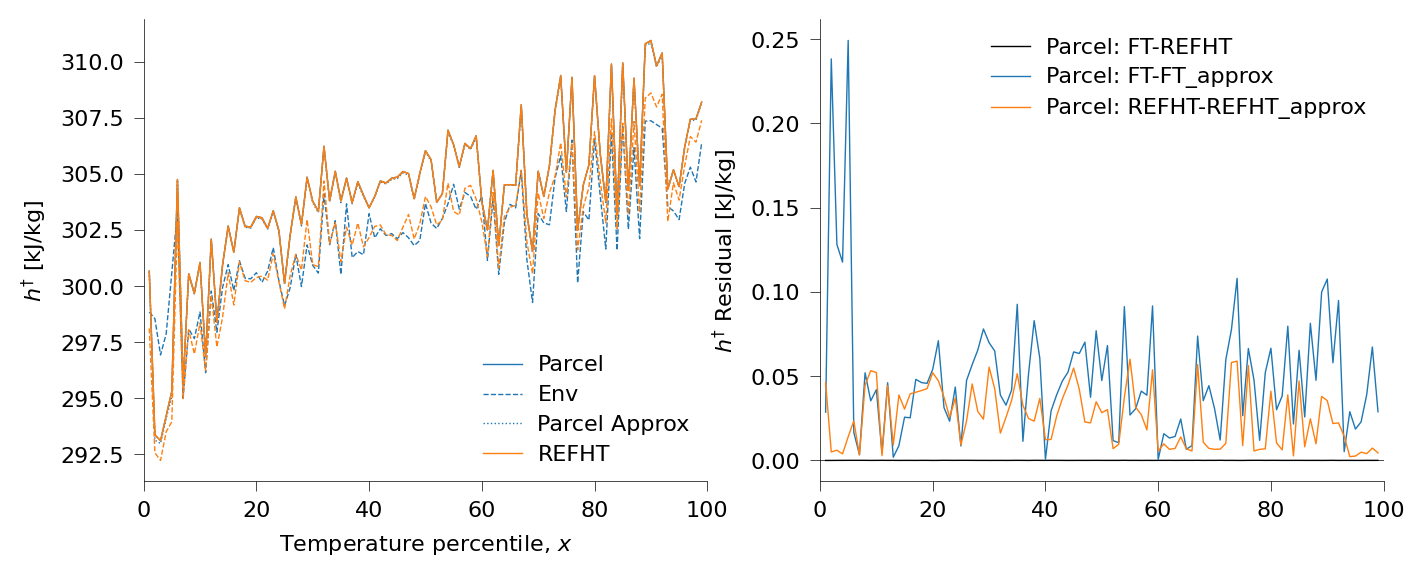

6.0510248772516206e-05


In [69]:
fig, ax = plt.subplots(1, 2, sharex=True)
fig_resize(fig, 8)
ax[0].plot(ds_use.quant, mse_mod_ft_parcel, label='Parcel', color='C0')
ax[0].plot(ds_use.quant, mse_mod_ft_env, label='Env', color='C0', linestyle='--')
ax[0].plot(ds_use.quant,
           mse_mod_ft_parcel_approx, label='Parcel Approx', color='C0', linestyle=':')

ax[0].plot(ds_use.quant, mse_mod_REFHT_parcel, label='REFHT', color='C1')
ax[0].plot(ds_use.quant, mse_mod_REFHT_env, color='C1', linestyle='--')
ax[0].plot(ds_use.quant, mse_mod_REFHT_parcel_approx, color='C1', linestyle=':')

ax[0].legend()
ax[0].set_xlabel('Temperature percentile, $x$')
ax[0].set_ylabel('$h^{\dagger}$ [kJ/kg]')

ax[1].plot(ds_use.quant, mse_mod_ft_parcel - mse_mod_REFHT_parcel, label='Parcel: FT-REFHT', color='k')
ax[1].plot(ds_use.quant, mse_mod_ft_parcel_error, label='Parcel: FT-FT_approx', color='C0')
ax[1].plot(ds_use.quant, mse_mod_REFHT_parcel_error, label='Parcel: REFHT-REFHT_approx', color='C1')
ax[1].legend()
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].set_ylabel('$h^{\dagger}$ Residual [kJ/kg]')

update_fontsize(fig, 7)
ax[0].set_xlim(0, 100)
plt.show()

# Sanity check that parcel mod MSE is the same at surface and parcel
print(float(np.abs(mse_mod_REFHT_parcel - mse_mod_ft_parcel).max()))

# ax.plot(ds_quant.quant, mse_mod_REFHT_parcel.isel(sample=0, surf=0, lat=0))
# plt.plot(ds_quant.quant, mse_mod_ft_env.isel(sample=0, surf=0, lat=0))
# plt.plot(ds_quant.quant, mse_mod_ft_parcel_approx.isel(sample=0, surf=0, lat=0))

### Breakdown of approximation of $h^{\dagger}_{FT}$
Above, we see for large $x$, the error of the approximation of $h^{\dagger}_{FT}$ is significant. This is because the quantity $\frac{R}{g}\eta_M\ln(\frac{r_s^{\nu}}{\sigma_{FT}})T_{FT}$ that we are doing a Taylor expansion in gets quite large as shown below.

We also show that the parameter for *REFHT* is much smaller, and thus the error is smaller.

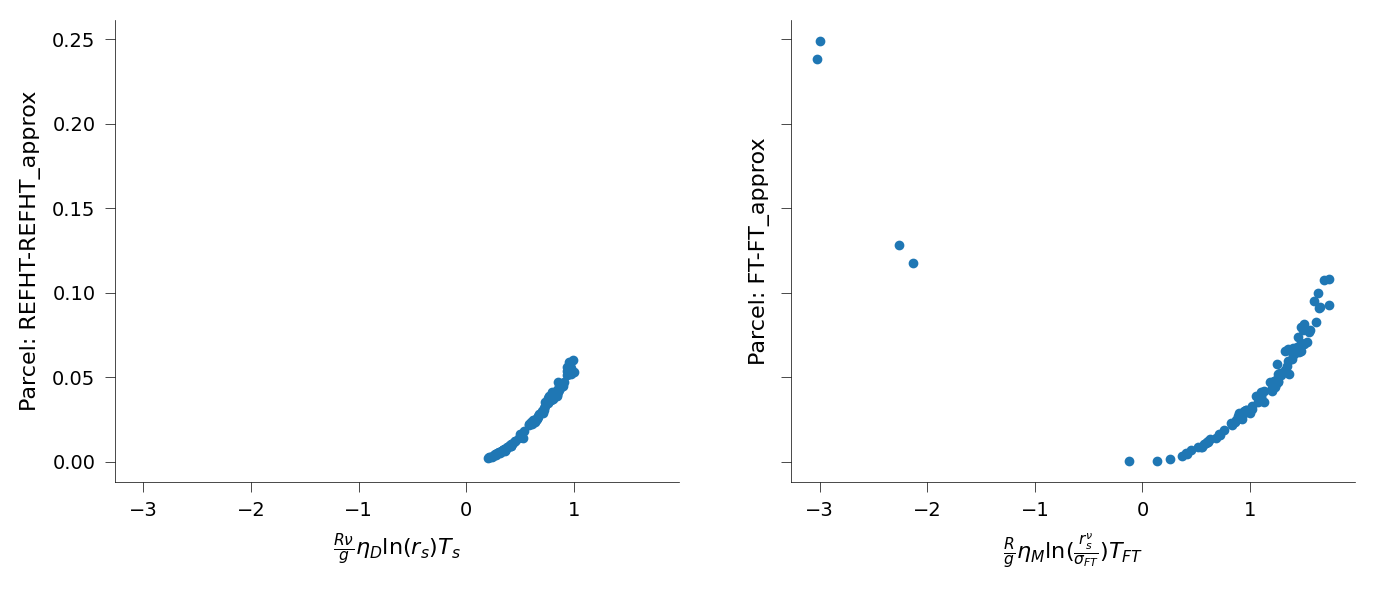

In [70]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 8)

exponent_use = R * (ds_use['modParc1_lapse'].isel(layer=0) / 1000 - lapse_dry) / g
if do_taylor_expansion:
    var = ds_use.TREFHT * exponent_use * np.log(ds_use['sigma_lcl'])
else:
    var = (ds_use['sigma_lcl'] ** exponent_use - 1) * ds_use.TREFHT
ax[0].scatter(var, mse_mod_REFHT_parcel_error)
ax[0].set_ylabel('Parcel: REFHT-REFHT_approx')
ax[0].set_xlabel('$\\frac{R\\nu}{g}\eta_D \ln (r_s) T_s$')

exponent_use = R * (ds_use['modParc1_lapse'].isel(layer=1) / 1000) / g
if do_taylor_expansion:
    var = ds_use['T_ft_env'] * exponent_use * np.log(ds_use['sigma_lcl'] / (p_ft / ds_use.PREFHT))
else:
    var = (ds_use['sigma_lcl'] ** exponent_use * (p_ft / ds_use.PREFHT) ** (-exponent_use) - 1) * ds_use['T_ft_env']

ax[1].scatter(var, mse_mod_ft_parcel_error)
ax[1].set_ylabel('Parcel: FT-FT_approx')
ax[1].set_xlabel('$\\frac{R}{g}\eta_M\ln(\\frac{r_s^{\\nu}}{\sigma_{FT}})T_{FT}$')
plt.show()

### $\epsilon$ Approximation
Above we showed that

* $h^{\dagger}_{parc} = h^{\dagger}_{FTenv} + \beta_{FT1}\frac{R}{g}\eta_M\ln(\frac{r_s^{\nu}}{\sigma_{FT}})T_{FT} + A_{\eta_M}$
* $h^{\dagger}_{parc} = h^{\dagger}_{senv} + \beta_{s1} \frac{R\nu}{g}\eta_D \ln (r_s) T_s + A_{\eta_D}$

where $A_{\eta_M}$ is a taylor series error associated with assuming $\eta_M$ is small, and $A_{\eta_D}$ is a taylor series approximation associated with assuming $\eta_D$ is small.

Then $\epsilon = h_s - h^*_{FT} = h^{\dagger}_{senv} - h^{\dagger}_{FTenv} - A_z$. And upon equating the above equations for $h^{\dagger}_{parc}$, we get:

$\epsilon = -A_z + A_{\eta_M} - A_{\eta_D} + \beta_{FT1}\frac{R}{g}\eta_M\ln(\frac{r_s^{\nu}}{\sigma_{FT}})T_{FT} - \beta_{s1} \frac{R\nu}{g}\eta_D \ln (r_s) T_s$

Note that the difference between the Theory and Theory+Error line below includes the effect of $A_z$, but in the scaling factor derivation this will cancel out, so no need to worry about it.

In [71]:
epsilon_theory = (mse_mod_ft_parcel_approx - mse_mod_ft_env) - (mse_mod_REFHT_parcel_approx - mse_mod_REFHT_env)
epsilon_error = -z_error + mse_mod_ft_parcel_error - mse_mod_REFHT_parcel_error

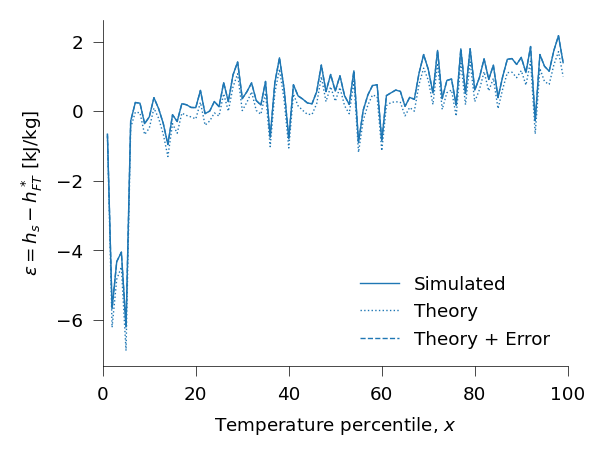

8.977523761366513e-05


In [72]:
fig, ax = plt.subplots(1, 1)
fig_resize(fig, 3)
ax.plot(ds_use.quant, ds_use.epsilon,
        label='Simulated', color='C0')
ax.plot(ds_use.quant, epsilon_theory,
        label='Theory',
        color='C0', linestyle=':')
ax.plot(ds_use.quant,
        (epsilon_theory + epsilon_error),
        label='Theory + Error',
        color='C0', linestyle='--')

ax.legend()
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('$\epsilon = h_s - h_{FT}^*$ [kJ/kg]')
update_fontsize(fig, 7)
ax.set_xlim(0, 100)
plt.show()

# Sanity check that theory and error are exact
print(float(np.abs(ds_use.epsilon - (epsilon_theory + epsilon_error)).max()))

### Epsilon Approx Function
Below I put the above code for computing an approximation for $\epsilon$ in a function, and check it gives the same result. Also check that $A_{\eta_M}$ and $A_{\eta_D}$ are the same.

In [73]:
def get_epsilon_theory(temp_surf, temp_ft, rh_surf, p_surf, lapse_diff_D, lapse_diff_M, p_ft=p_ft,
                       temp_lcl_ref=temp_lcl_bolton_use, do_taylor_expansion=do_taylor_expansion):
    R_mod, _, _, beta_ft1, _, _, _ = get_theory_prefactor_terms(temp_ft, p_surf, p_ft)
    beta_s1 = get_theory_prefactor_terms(temp_surf, p_surf, p_ft, sphum=rh_surf * sphum_sat(temp_surf, p_surf))[3]
    exponent_use = R * lapse_diff_M / g
    sigma_lcl = lcl_sigma_bolton_simple(rh_surf, temp_lcl_ref)
    sigma_ft = p_ft / p_surf
    if do_taylor_expansion:
        cont_ft = beta_ft1 * temp_ft * exponent_use * np.log(sigma_lcl / sigma_ft)
    else:
        cont_ft = beta_ft1 * (sigma_lcl ** exponent_use * sigma_ft ** (-exponent_use) - 1) * temp_ft
    exponent_use = R * lapse_diff_D / g
    if do_taylor_expansion:
        cont_surf = beta_s1 * temp_surf * exponent_use * np.log(sigma_lcl)
    else:
        cont_surf = beta_s1 * (sigma_lcl ** exponent_use - 1) * temp_surf
    return (cont_ft - cont_surf) / 1000, cont_ft / 1000, cont_surf / 1000


def get_epsilon_error(temp_surf, temp_ft, rh_surf, p_surf, lapse_diff_D, lapse_diff_M, p_ft=p_ft,
                      temp_lcl_ref=temp_lcl_bolton_use, do_taylor_expansion=do_taylor_expansion):
    # Returns the error terms A_{\eta_D} and A{\eta_M}
    # Ignores the z error term - deal with separately
    sigma_lcl = lcl_sigma_bolton_simple(rh_surf, temp_lcl_ref)
    sigma_ft = p_ft / p_surf
    exponent_use = R * lapse_diff_M / g
    temp_ft_parcel = temp_ft * sigma_lcl ** exponent_use * sigma_ft ** (-exponent_use)
    exponent_use = R * lapse_diff_D / g
    temp_surf_parcel = temp_surf * sigma_lcl ** exponent_use

    mse_mod_ft_parcel = ((c_p + R_mod) * temp_ft_parcel + L_v * sphum_sat(temp_ft_parcel, p_ft))
    mse_mod_ft_env = ((c_p + R_mod) * temp_ft + L_v * sphum_sat(temp_ft, p_ft))

    mse_mod_surf_parcel = ((c_p - R_mod) * temp_surf_parcel + L_v * rh_surf * sphum_sat(temp_surf_parcel, p_surf))
    mse_mod_surf_env = ((c_p - R_mod) * temp_surf + L_v * rh_surf * sphum_sat(temp_surf, p_surf))

    # epsilon_exact = ((mse_mod_ft_parcel - mse_mod_ft_env) - (mse_mod_surf_parcel - mse_mod_surf_env)) / 1000
    cont_ft_approx, cont_surf_approx = get_epsilon_theory(temp_surf, temp_ft, rh_surf, p_surf, lapse_diff_D,
                                                          lapse_diff_M, p_ft,
                                                          temp_lcl_bolton_use, do_taylor_expansion)[1:]
    error_ft = (mse_mod_ft_parcel - mse_mod_ft_env) / 1000 - cont_ft_approx
    error_surf = (mse_mod_surf_parcel - mse_mod_surf_env) / 1000 - cont_surf_approx
    return error_ft, error_surf


ds_use['epsilon_approx'] = get_epsilon_theory(ds_use.TREFHT, ds_use.T_ft_env, ds_use.rh_REFHT, ds_use.PREFHT,
                                              ds_use.modParc1_lapse.isel(layer=0) / 1000 - lapse_dry,
                                              ds_use.modParc1_lapse.isel(layer=1) / 1000)[0]
print(float(np.abs(ds_use['epsilon_approx'] - epsilon_theory).max()))

mse_mod_ft_parcel_error2, mse_mod_REFHT_parcel_error2 = get_epsilon_error(ds_use.TREFHT, ds_use.T_ft_env,
                                                                          ds_use.rh_REFHT, ds_use.PREFHT,
                                                                          ds_use.modParc1_lapse.isel(
                                                                              layer=0) / 1000 - lapse_dry,
                                                                          ds_use.modParc1_lapse.isel(layer=1) / 1000)
print(float(np.abs(mse_mod_ft_parcel_error2 - mse_mod_ft_parcel_error).max()))
print(float(np.abs(mse_mod_REFHT_parcel_error2 - mse_mod_REFHT_parcel_error).max()))

3.0025839805603027e-05
0.00015567356689416556
4.2438507080078125e-05


### Single Sample - Decomposition of $\epsilon$ contributions
Given the above theory for $\epsilon$, we now decompose the contribution due to each physical variable: $T_s, T_{FT}, r_s, p_s, \eta_D, \eta_M$.

By definition, $\epsilon=0$ if $\eta_D = \eta_M = 0$. So we only consider the actual values of $\eta_D$ and $\eta_M$, then consider the non linear contributions from variation of other parameters too.

In [74]:
ds_use['lapse_diff_D'] = ds_use.modParc1_lapse.isel(layer=0) / 1000 - lapse_dry
ds_use['lapse_diff_M'] = ds_use.modParc1_lapse.isel(layer=1) / 1000

ds_ref = ds_use[['TREFHT', 'rh_REFHT', 'PREFHT']].median(dim='quant')
# Ensure ref values of rh and P have same value for all tau_lw. Set to coldest simulation
# ds_ref['rh_REFHT'] = ds_ref['rh_REFHT'] * 0 + ds_ref['rh_REFHT'].isel(tau_lw=0)
# ds_ref['PREFHT'] = ds_ref['PREFHT'] * 0 + ds_ref['PREFHT'].isel(tau_lw=0)
# Compute T_ft assuming perfectly SQE - two functions both give same answer
# ds_ref['T_ft_env'] = xr.apply_ufunc(get_temp_adiabat, ds_ref.TREFHT,
#                                     ds_ref.rh_REFHT * sphum_sat(ds_ref['TREFHT'], ds_ref.PREFHT),
#                                     ds_ref.PREFHT,
#                                     input_core_dims=[[], [], []], vectorize=True, kwargs={'pressure_ft': p_ft})
ds_ref['T_ft_env'] = xr.apply_ufunc(get_temp_mod_parcel, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                    p_ft, 0, 0, ds_ref['TREFHT'],
                                    input_core_dims=[[], [], [], [], [], []], vectorize=True,
                                    kwargs={'temp_surf_lcl_calc': temp_lcl_bolton_use})
# For lapse rate params, ref value cannot be zero, but make it the value in the colder simulation
ds_ref['lapse_diff_D'] = ds_use['lapse_diff_D']
ds_ref['lapse_diff_M'] = ds_use['lapse_diff_M']

In [75]:
def get_epsilon_cont_analytic(temp_surf=ds_use.TREFHT, temp_ft=ds_use.T_ft_env, rh_surf=ds_use.rh_REFHT,
                              p_surf=ds_use.PREFHT,
                              lapse_diff_D=ds_use.lapse_diff_D, lapse_diff_M=ds_use.lapse_diff_M,
                              temp_surf_ref=ds_ref.TREFHT, temp_ft_ref=ds_ref.T_ft_env, rh_surf_ref=ds_ref.rh_REFHT,
                              p_surf_ref=ds_ref.PREFHT, lapse_diff_D_ref=0, lapse_diff_M_ref=0, p_ft=p_ft,
                              temp_lcl_ref=temp_lcl_bolton_use, do_taylor_expansion=do_taylor_expansion):
    if not do_taylor_expansion:
        raise ValueError('This analytic assumes the extra taylor series')
    # Compute all params with reference quantities
    R_mod, _, _, beta_ft1, _, _, _ = get_theory_prefactor_terms(temp_ft_ref, p_surf_ref, p_ft)
    beta_s1 = get_theory_prefactor_terms(temp_surf_ref, p_surf_ref, p_ft,
                                         sphum=rh_surf_ref * sphum_sat(temp_surf_ref, p_surf_ref))[3]
    sigma_lcl = lcl_sigma_bolton_simple(rh_surf_ref, temp_lcl_ref)
    sigma_exponent = np.log(sigma_lcl) / np.log(rh_surf_ref)
    sigma_ft = p_ft / p_surf_ref

    cont = {}
    cont['lapse_D'] = -beta_s1 * temp_surf_ref * R / g * np.log(sigma_lcl) * (lapse_diff_D - lapse_diff_D_ref)
    cont['lapse_M'] = beta_ft1 * temp_ft_ref * R / g * np.log(sigma_lcl / sigma_ft) * (lapse_diff_M - lapse_diff_M_ref)
    cont['rh_REFHT'] = cont['lapse_D'] / np.log(sigma_lcl) * sigma_exponent * (rh_surf - rh_surf_ref) / rh_surf_ref
    cont['rh_REFHT'] += cont['lapse_M'] / np.log(sigma_lcl / sigma_ft) * sigma_exponent * (
                rh_surf - rh_surf_ref) / rh_surf_ref
    for key in cont:
        cont[key] /= 1000
    return cont

In [76]:
# Get numerical contributions
ds_eps_num = ds_use[['TREFHT']]
ds_eps_num['lapse_D'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                           ds_use['lapse_diff_D'], 0)[0]
ds_eps_num['lapse_M'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                           0, ds_use['lapse_diff_M'])[0]
ds_eps_num = ds_eps_num.drop_vars('TREFHT')

ds_eps_num['TREFHT'] = get_epsilon_theory(ds_use.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                          ds_use['lapse_diff_D'], ds_use['lapse_diff_M'])[0]
ds_eps_num['TREFHT'] = ds_eps_num['TREFHT'] - ds_eps_num['lapse_D'] - ds_eps_num['lapse_M']

ds_eps_num['T_ft_env'] = get_epsilon_theory(ds_ref.TREFHT, ds_use.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                            ds_use['lapse_diff_D'], ds_use['lapse_diff_M'])[0]
ds_eps_num['T_ft_env'] = ds_eps_num['T_ft_env'] - ds_eps_num['lapse_D'] - ds_eps_num['lapse_M']

ds_eps_num['rh_REFHT'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_use.rh_REFHT, ds_ref.PREFHT,
                                            ds_use['lapse_diff_D'], ds_use['lapse_diff_M'])[0]
ds_eps_num['rh_REFHT'] = ds_eps_num['rh_REFHT'] - ds_eps_num['lapse_D'] - ds_eps_num['lapse_M']

ds_eps_num['PREFHT'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_use.PREFHT,
                                          ds_use['lapse_diff_D'], ds_use['lapse_diff_M'])[0]
ds_eps_num['PREFHT'] = ds_eps_num['PREFHT'] - ds_eps_num['lapse_D'] - ds_eps_num['lapse_M']

# Get analytic contributions
ds_eps_an = get_epsilon_cont_analytic()

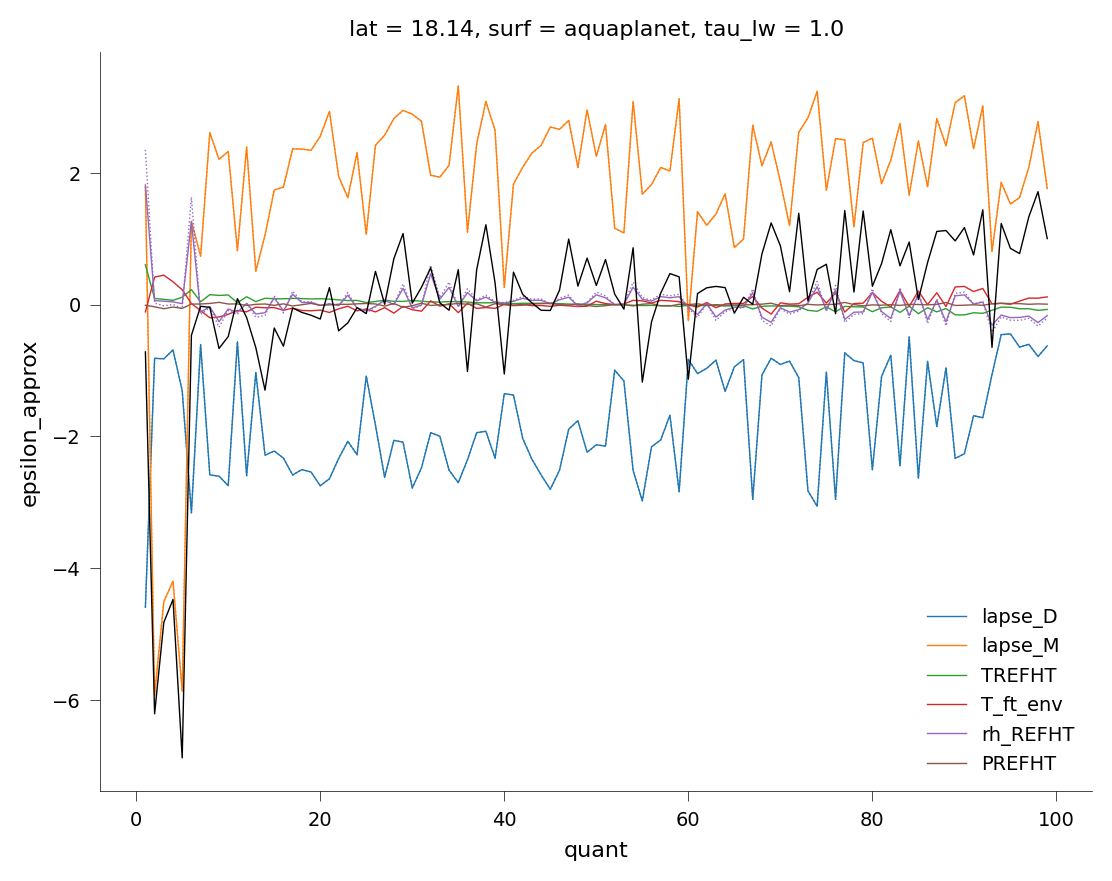

In [77]:
for j, key in enumerate(ds_eps_num):
    ds_eps_num[key].plot(color=f"C{j}", label=key)
    if key in ds_eps_an:
        ds_eps_an[key].plot(color=f"C{j}", linestyle=':')
# ds_eps['lapse_M'].plot()
ds_use['epsilon_approx'].plot(color='k')
# (ds_eps['lapse_D']+ds_eps['lapse_M']).plot(color='k', linestyle=':')
plt.gca().legend()
# ds_eps['lapse_M'].plot()

### Average over samples
For the scaling factor theory, we average over samples for a given quantile for each variable. The $\epsilon$ computed using these average variables may not equal the average of epsilon. We investigate that below.

I.e. $\overline{\epsilon} \neq \epsilon(\overline{T}_s, \overline{T}_{FT}, \overline{r}_s, ...)$

We write $A_{\epsilon \text{av}} = \overline{\epsilon} - \hat{\epsilon}(\overline{\chi})-A_z + A_{\eta_M} - A_{\eta_D}$

where the overline is an average over sample, and $\hat{\epsilon}$ is the theoretical $\epsilon$, and $\chi$ refers to all variables required to compute this.

Below we see that $A_{\epsilon \text{av}}$ has comparable magnitude to the other errors.


In [107]:
ds_av = ds_quant['aquaplanet'].mean(dim='sample')
ds_av['rh_REFHT'] = ds_av.QREFHT / sphum_sat(ds_av.TREFHT, ds_av.PREFHT)
ds_av['mse_REFHT'] = moist_static_energy(ds_av.TREFHT, ds_av.QREFHT, ds_av.ZREFHT)
ds_av['mse_ft_sat_env'] = moist_static_energy(ds_av.T_ft_env, sphum_sat(ds_av.T_ft_env, p_ft), ds_av.Z_ft_env)
ds_av['epsilon'] = ds_av['mse_REFHT'] - ds_av['mse_ft_sat_env']
ds_av['lapse_diff_D'] = ds_av.modParc1_lapse.isel(layer=0) / 1000 - lapse_dry
ds_av['lapse_diff_M'] = ds_av.modParc1_lapse.isel(layer=1) / 1000

In [108]:
ds_av['epsilon_approx'] = get_epsilon_theory(ds_av.TREFHT, ds_av.T_ft_env, ds_av.rh_REFHT, ds_av.PREFHT,
                                             ds_av['lapse_diff_D'],
                                             ds_av['lapse_diff_M'])[0]
ds_av['lapse_M_error'], ds_av['lapse_D_error'] = get_epsilon_error(ds_av.TREFHT, ds_av.T_ft_env,
                                                                 ds_av.rh_REFHT, ds_av.PREFHT,
                                                                 ds_av.modParc1_lapse.isel(layer=0) / 1000 - lapse_dry,
                                                                 ds_av.modParc1_lapse.isel(layer=1) / 1000)
def get_z_error(ds):
    R_mod = get_theory_prefactor_terms(ds.T_ft_env, ds.PREFHT, p_ft)[0]
    z_diff = g * (ds.Z_ft_env - ds.ZREFHT)
    z_diff_theory = R_mod * (ds.TREFHT + ds.T_ft_env)
    z_error = (z_diff - z_diff_theory) / 1000  # units of kJ/kg
    return z_error
ds_av['z_error'] = get_z_error(ds_av)
# Averging error is the residual error after accounting for z_error, lapse_m_error and lapse_d_error
ds_av['epsilon_av_error'] = ds_av['epsilon'] - (ds_av['epsilon_approx']-ds_av['z_error'] + ds_av['lapse_M_error'] - ds_av['lapse_D_error'])

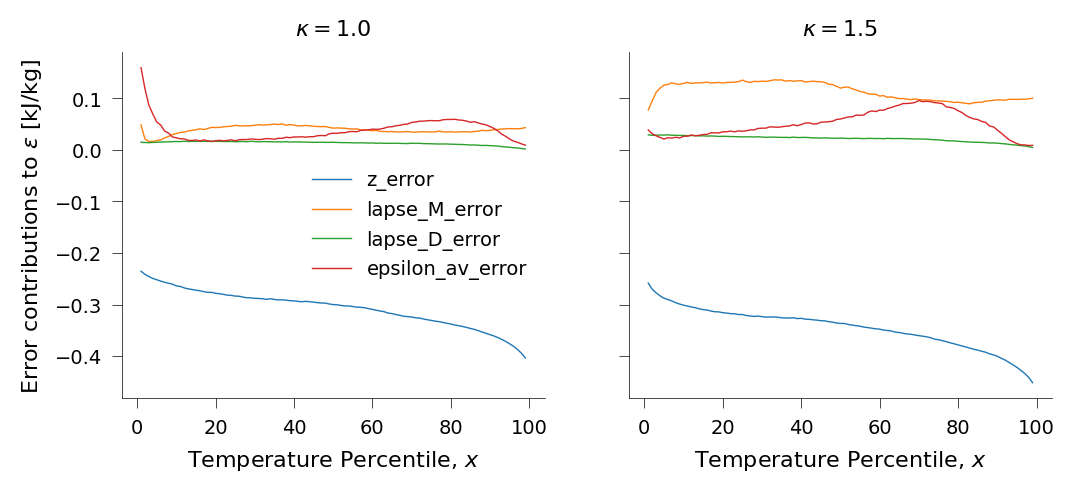

In [131]:
lat_weights = np.cos(np.deg2rad(ds_av.lat))
percentile_label = 'Temperature Percentile, $x$'

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 6)
for j in range(ds_av.tau_lw.size):
    ax[j].set_xlabel(percentile_label)
    ax[j].set_title(f"$\kappa = {ds_av.tau_lw[j]:.1f}$")
    for i, key in enumerate(['z_error', 'lapse_M_error', 'lapse_D_error', 'epsilon_av_error']):
        ax[j].plot(ds_av.quant, np.average(ds_av[key].isel(tau_lw=j), weights=lat_weights, axis=1), color=f"C{i}", label=key)
ax[0].legend()
ax[0].set_ylabel('Error contributions to $\epsilon$ [kJ/kg]')
plt.show()

In [132]:
ds_av_ref = ds_av[['TREFHT', 'rh_REFHT', 'PREFHT']].median(dim='quant')
# Ensure ref values of rh and P have same value for all tau_lw. Set to coldest simulation
# ds_av_ref['rh_REFHT'] = ds_av_ref['rh_REFHT'] * 0 + ds_av_ref['rh_REFHT'].isel(tau_lw=0)
# ds_av_ref['PREFHT'] = ds_av_ref['PREFHT'] * 0 + ds_av_ref['PREFHT'].isel(tau_lw=0)
# Compute T_ft assuming perfectly SQE - two functions both give same answer
ds_av_ref['T_ft_env'] = xr.apply_ufunc(get_temp_mod_parcel, ds_av_ref.rh_REFHT, ds_av_ref.PREFHT,
                                    p_ft, 0, 0, ds_av_ref['TREFHT'],
                                    input_core_dims=[[], [], [], [], [], []], vectorize=True,
                                    kwargs={'temp_surf_lcl_calc': temp_lcl_bolton_use})
# For lapse rate params, ref value cannot be zero, but make it the value in the colder simulation
ds_av_ref['lapse_diff_D'] = ds_av['lapse_diff_D']
ds_av_ref['lapse_diff_M'] = ds_av['lapse_diff_M']

In [134]:
# Get numerical contributions
ds_av_eps = ds_av[['TREFHT']]
ds_av_eps['lapse_D'] = get_epsilon_theory(ds_av_ref.TREFHT, ds_av_ref.T_ft_env, ds_av_ref.rh_REFHT, ds_av_ref.PREFHT,
                                           ds_av['lapse_diff_D'], 0)[0]
ds_av_eps['lapse_M'] = get_epsilon_theory(ds_av_ref.TREFHT, ds_av_ref.T_ft_env, ds_av_ref.rh_REFHT, ds_av_ref.PREFHT,
                                           0, ds_av['lapse_diff_M'])[0]
ds_av_eps = ds_av_eps.drop_vars('TREFHT')

ds_av_eps['TREFHT'] = get_epsilon_theory(ds_av.TREFHT, ds_av_ref.T_ft_env, ds_av_ref.rh_REFHT, ds_av_ref.PREFHT,
                                          ds_av['lapse_diff_D'], ds_av['lapse_diff_M'])[0]
ds_av_eps['TREFHT'] = ds_av_eps['TREFHT'] - ds_av_eps['lapse_D'] - ds_av_eps['lapse_M']

ds_av_eps['T_ft_env'] = get_epsilon_theory(ds_av_ref.TREFHT, ds_av.T_ft_env, ds_av_ref.rh_REFHT, ds_av_ref.PREFHT,
                                            ds_av['lapse_diff_D'], ds_av['lapse_diff_M'])[0]
ds_av_eps['T_ft_env'] = ds_av_eps['T_ft_env'] - ds_av_eps['lapse_D'] - ds_av_eps['lapse_M']

ds_av_eps['rh_REFHT'] = get_epsilon_theory(ds_av_ref.TREFHT, ds_av_ref.T_ft_env, ds_av.rh_REFHT, ds_av_ref.PREFHT,
                                            ds_av['lapse_diff_D'], ds_av['lapse_diff_M'])[0]
ds_av_eps['rh_REFHT'] = ds_av_eps['rh_REFHT'] - ds_av_eps['lapse_D'] - ds_av_eps['lapse_M']

ds_av_eps['PREFHT'] = get_epsilon_theory(ds_av_ref.TREFHT, ds_av_ref.T_ft_env, ds_av_ref.rh_REFHT, ds_av.PREFHT,
                                          ds_av['lapse_diff_D'], ds_av['lapse_diff_M'])[0]
ds_av_eps['PREFHT'] = ds_av_eps['PREFHT'] - ds_av_eps['lapse_D'] - ds_av_eps['lapse_M']

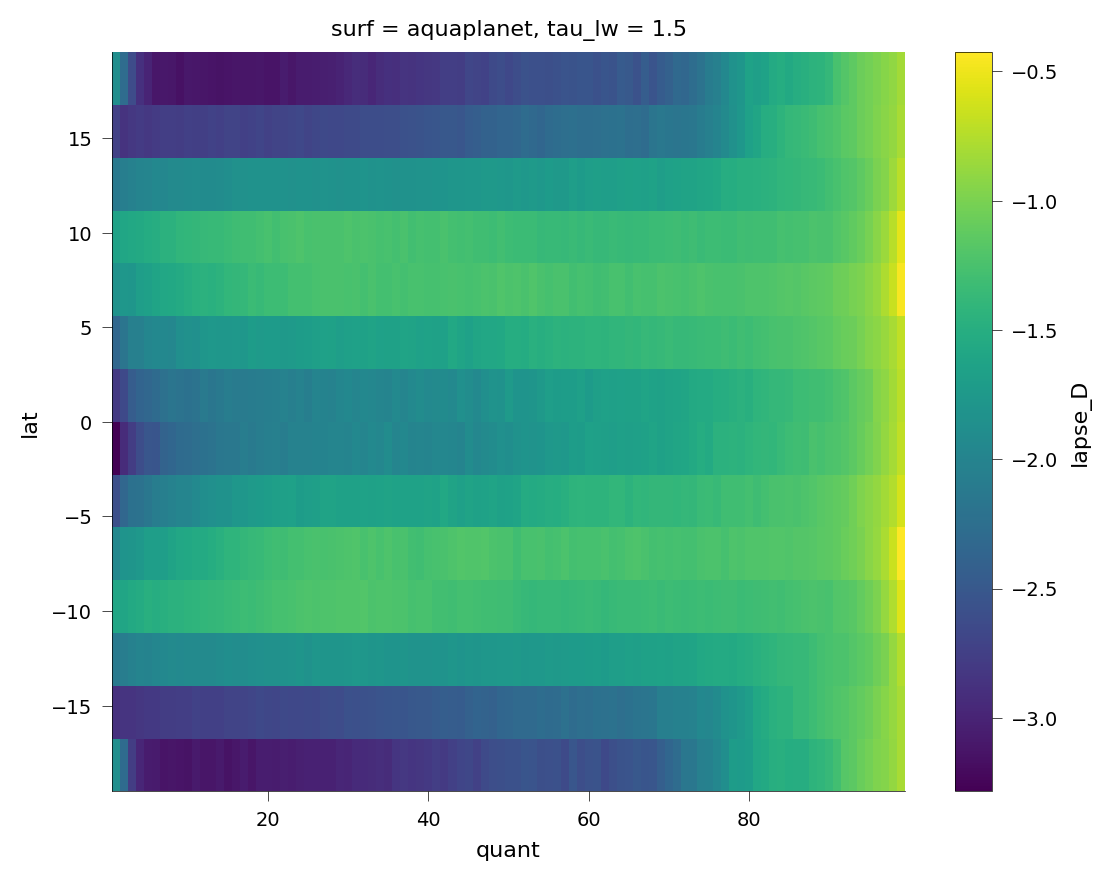

In [149]:
ds_av_eps['lapse_D'].isel(tau_lw=1).plot()

In [178]:
ds_eps = ds_use[['TREFHT']]
ds_eps['lapse_D'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                       ds_use['lapse_diff_D'], 0)[0]
ds_eps['lapse_M'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                       0, ds_use['lapse_diff_M'])[0]
ds_eps = ds_eps.drop_vars('TREFHT')

# ds_eps['TREFHT'] = get_epsilon_theory(ds_use.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
#                                       ds_use['lapse_diff_D'], ds_use['lapse_diff_M'])
# ds_eps['TREFHT'] = ds_eps['TREFHT'] - ds_eps['lapse_D'] - ds_eps['lapse_M']
#
# ds_eps['T_ft_env'] = get_epsilon_theory(ds_ref.TREFHT, ds_use.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
#                                         ds_use['lapse_diff_D'], ds_use['lapse_diff_M'])
# ds_eps['T_ft_env'] = ds_eps['T_ft_env'] - ds_eps['lapse_D'] - ds_eps['lapse_M']
#
# ds_eps['rh_REFHT'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_use.rh_REFHT, ds_ref.PREFHT,
#                                         ds_use['lapse_diff_D'], ds_use['lapse_diff_M'])
# ds_eps['rh_REFHT'] = ds_eps['rh_REFHT'] - ds_eps['lapse_D'] - ds_eps['lapse_M']
#
# ds_eps['PREFHT'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_use.PREFHT,
#                                       ds_use['lapse_diff_D'], ds_use['lapse_diff_M'])
# ds_eps['PREFHT'] = ds_eps['PREFHT'] - ds_eps['lapse_D'] - ds_eps['lapse_M']
#
# ds_eps = ds_eps.transpose('quant', 'surf', 'tau_lw', 'lat', 'sample')


In [28]:
ds_eps2 = copy.deepcopy(ds_eps)
eps2_ref_cont = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT,
                                   ds_ref.PREFHT, ds_ref['lapse_diff_D'], ds_ref['lapse_diff_M'])
ds_eps2['TREFHT'] = get_epsilon_theory(ds_quant.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                       ds_ref['lapse_diff_D'], ds_ref['lapse_diff_M']) - eps2_ref_cont

ds_eps2['T_ft_env'] = get_epsilon_theory(ds_ref.TREFHT, ds_quant.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                         ds_ref['lapse_diff_D'], ds_ref['lapse_diff_M']) - eps2_ref_cont

ds_eps2['rh_REFHT'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_quant.rh_REFHT, ds_ref.PREFHT,
                                         ds_ref['lapse_diff_D'], ds_ref['lapse_diff_M']) - eps2_ref_cont

ds_eps2['PREFHT'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_quant.PREFHT,
                                       ds_ref['lapse_diff_D'], ds_ref['lapse_diff_M']) - eps2_ref_cont

ds_eps2 = ds_eps2.transpose('quant', 'surf', 'tau_lw', 'lat', 'sample')

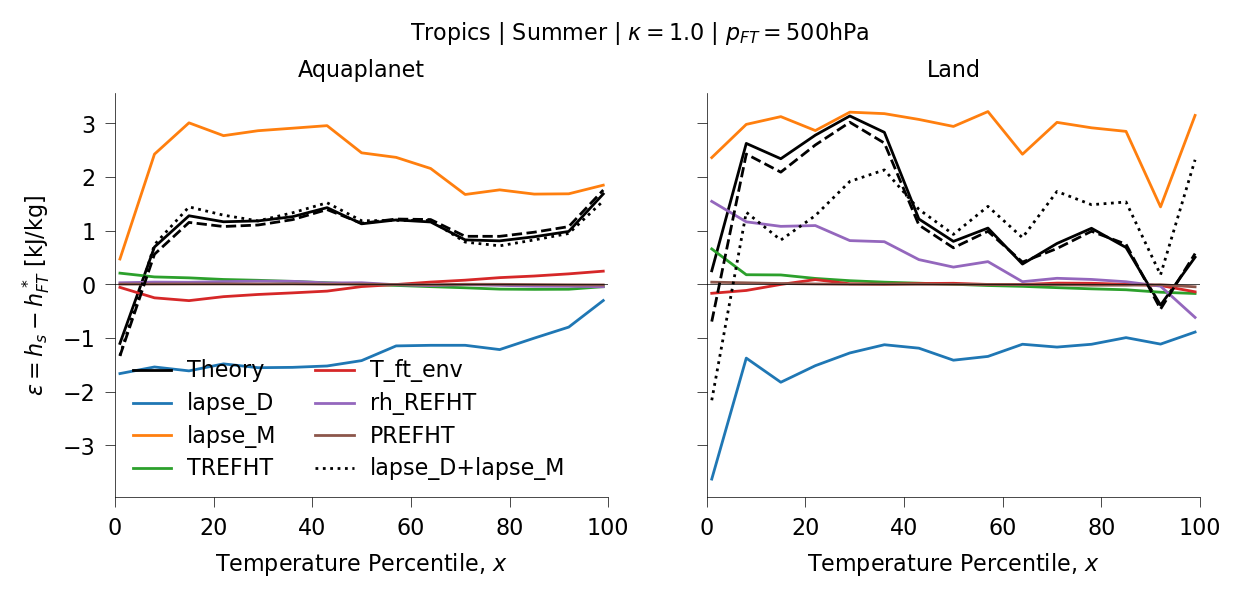

In [29]:
tau_lw_ind = 0
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 7)
for k in range(ds.surf.size):
    ax[k].set_title(ds_quant.surf.values[k].capitalize())
    ax[k].plot(ds_quant.quant,
               np.average(epsilon_theory.isel(surf=k, tau_lw=tau_lw_ind).quantile(0.5, dim='sample'), axis=1,
                          weights=lat_weights),
               color='k', label='Theory')
    for j, key in enumerate(ds_eps):
        ax[k].plot(ds_quant.quant,
                   np.average(ds_eps[key].isel(surf=k, tau_lw=tau_lw_ind).quantile(0.5, dim='sample'), axis=1,
                              weights=lat_weights),
                   color=f'C{j}', label=key)
    ax[k].plot(ds_quant.quant, np.average(
        (ds_eps['lapse_D'] + ds_eps['lapse_M']).isel(surf=k, tau_lw=tau_lw_ind).quantile(0.5, dim='sample'),
        axis=1, weights=lat_weights), color=f'k', linestyle=':', label='lapse_D+lapse_M')
    ax[k].plot(ds_quant.quant,
               np.average((ds_eps['lapse_D'] + ds_eps['lapse_M'] + ds_eps['rh_REFHT'] + ds_eps['T_ft_env']
                           ).isel(surf=k, tau_lw=tau_lw_ind).quantile(0.5, dim='sample'),
                          axis=1, weights=lat_weights), color=f'k', linestyle='--')
# ax[k].fill_between(ds_quant.quant, np.average(epsilon_theory.isel(surf=k).quantile(0.25, dim='sample'), axis=1,
#                                               weights=lat_weights),
#                    np.average(epsilon_theory.isel(surf=k).quantile(0.75, dim='sample'), axis=1,
#                               weights=lat_weights), alpha=0.1, color='k', edgecolor="none")
update_linewidth(fig)
ax[0].legend(ncol=2)
fig.suptitle(
    f"{region.capitalize()} | {season.capitalize()} | $\kappa = {ds_quant.tau_lw.values[tau_lw_ind]}$ | $p_{'{FT}'} = {p_ft / 100:.0f}$hPa",
    y=1.02)
update_fontsize(fig)
ax[0].set_ylabel('$\epsilon = h_s - h_{FT}^*$ [kJ/kg]')
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
for k in range(ds.surf.size):
    ax[k].axhline(0, color='k', lw=ax_linewidth)
plt.show()

In [165]:
lat_weights = np.cos(np.deg2rad(ds.lat))
percentile_label = 'Temperature Percentile, $x$'

tau_lw_ind = 0
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 7)
for k in range(ds.surf.size):
    ax[k].set_title(ds_quant.surf.values[k].capitalize())
    ax[k].plot(ds_quant.quant,
               np.average(epsilon_theory.isel(surf=k, tau_lw=tau_lw_ind).quantile(0.5, dim='sample'), axis=1,
                          weights=lat_weights),
               color='k')
    ax[k].fill_between(ds_quant.quant,
                       np.average(epsilon_theory.isel(surf=k, tau_lw=tau_lw_ind).quantile(0.25, dim='sample'), axis=1,
                                  weights=lat_weights),
                       np.average(epsilon_theory.isel(surf=k, tau_lw=tau_lw_ind).quantile(0.75, dim='sample'), axis=1,
                                  weights=lat_weights), alpha=0.1, color='k', edgecolor="none")

update_linewidth(fig)
fig.suptitle(
    f"{region.capitalize()} | {season.capitalize()} | $\kappa = {ds_quant.tau_lw.values[tau_lw_ind]}$ | $p_{'{FT}'} = {p_ft / 100:.0f}$hPa",
    y=1.02)
update_fontsize(fig)
ax[0].set_ylabel('$\epsilon = h_s - h_{FT}^*$ [kJ/kg]')
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
for k in range(ds.surf.size):
    ax[k].axhline(0, color='k', lw=ax_linewidth)
plt.show()

NameError: name 'ds' is not defined

### Change between simulations
Here, I look at how the above contributions change with warming.

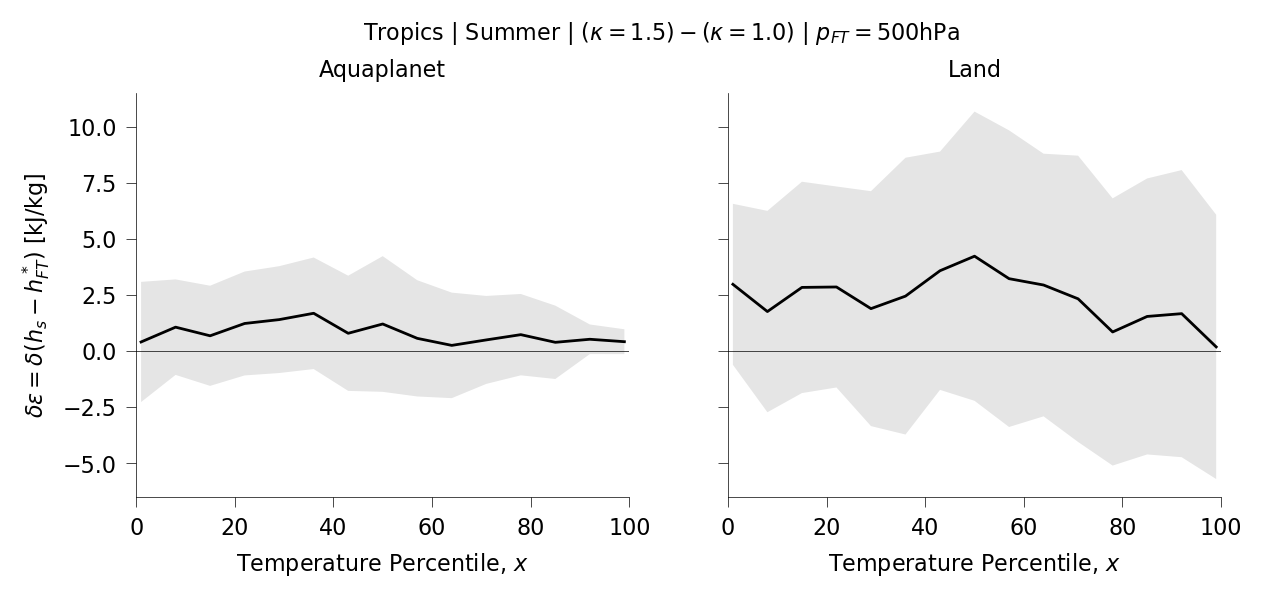

In [30]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 7)
for k in range(ds.surf.size):
    ax[k].set_title(ds_quant.surf.values[k].capitalize())
    var = epsilon_theory.isel(surf=k).quantile(0.5, dim='sample')
    ax[k].plot(ds_quant.quant,
               np.average(var.isel(tau_lw=1) - var.isel(tau_lw=0), axis=1, weights=lat_weights),
               color='k')
    error = np.sqrt(epsilon_theory.isel(surf=k, tau_lw=0).std(dim='sample') ** 2 +
                    epsilon_theory.isel(surf=k, tau_lw=1).std(dim='sample') ** 2)
    ax[k].fill_between(ds_quant.quant, np.average(var.isel(tau_lw=1) - var.isel(tau_lw=0) - error, axis=1,
                                                  weights=lat_weights),
                       np.average(var.isel(tau_lw=1) - var.isel(tau_lw=0) + error, axis=1,
                                  weights=lat_weights), alpha=0.1, color='k', edgecolor="none")

update_linewidth(fig)
fig.suptitle(
    f"{region.capitalize()} | {season.capitalize()} | $(\kappa = {ds_quant.tau_lw.values[1]}) - (\kappa = {ds_quant.tau_lw.values[0]})$ | "
    f"$p_{'{FT}'} = {p_ft / 100:.0f}$hPa", y=1.02)
update_fontsize(fig)
ax[0].set_ylabel('$\delta \epsilon = \delta (h_s - h_{FT}^*)$ [kJ/kg]')
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
for k in range(ds.surf.size):
    ax[k].axhline(0, color='k', lw=ax_linewidth)
plt.show()

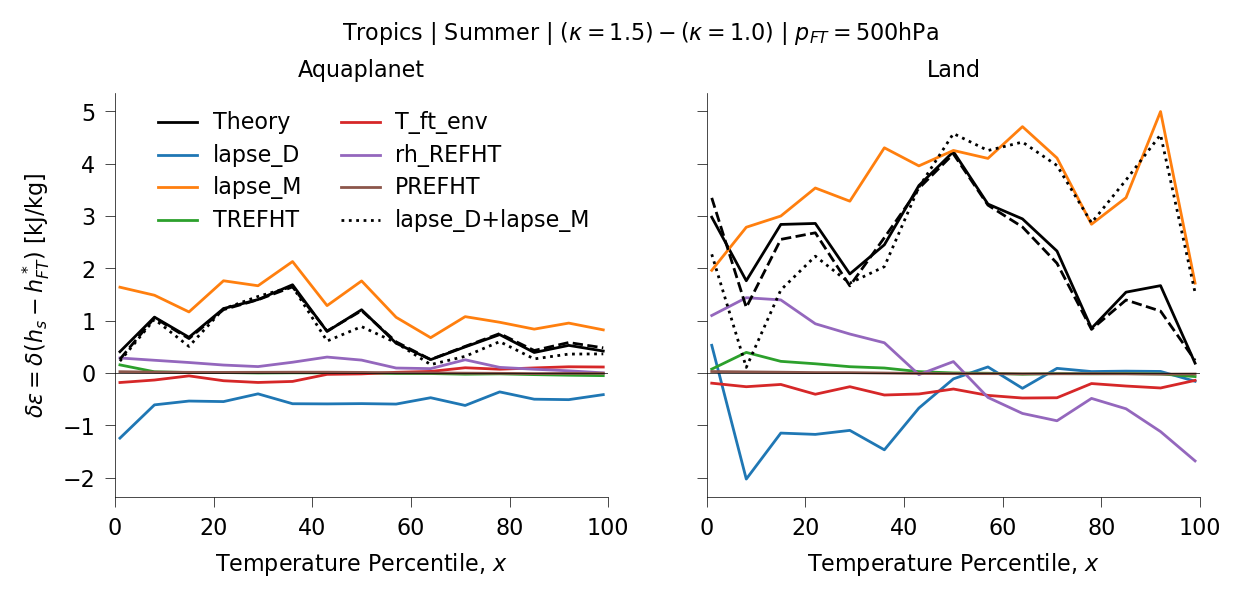

In [31]:
ds_use = ds_eps
# ds_use = ds_eps2        # For non-linear cont, takes colder sim value of lapse diff params
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 7)
for k in range(ds.surf.size):
    ax[k].set_title(ds_quant.surf.values[k].capitalize())
    var = epsilon_theory.isel(surf=k).quantile(0.5, dim='sample')
    ax[k].plot(ds_quant.quant,
               np.average(var.isel(tau_lw=1) - var.isel(tau_lw=0), axis=1, weights=lat_weights),
               color='k', label='Theory')
    for j, key in enumerate(ds_eps):
        ax[k].plot(ds_quant.quant,
                   np.average(ds_use[key].isel(surf=k, tau_lw=1).quantile(0.5, dim='sample') -
                              ds_use[key].isel(surf=k, tau_lw=0).quantile(0.5, dim='sample'), axis=1,
                              weights=lat_weights),
                   color=f'C{j}', label=key)
    var = (ds_use['lapse_D'] + ds_use['lapse_M']).quantile(0.5, dim='sample').isel(surf=k)
    ax[k].plot(ds_quant.quant, np.average(
        var.isel(tau_lw=1) - var.isel(tau_lw=0),
        axis=1, weights=lat_weights), color=f'k', linestyle=':', label='lapse_D+lapse_M')
    var = (ds_use['lapse_D'] + ds_use['lapse_M'] + ds_use['rh_REFHT'] + ds_use['T_ft_env']).quantile(0.5,
                                                                                                     dim='sample').isel(
        surf=k)
    ax[k].plot(ds_quant.quant, np.average(var.isel(tau_lw=1) - var.isel(tau_lw=0),
                                          axis=1, weights=lat_weights), color=f'k', linestyle='--')

update_linewidth(fig)
ax[0].legend(ncol=2)
fig.suptitle(
    f"{region.capitalize()} | {season.capitalize()} | $(\kappa = {ds_quant.tau_lw.values[1]}) - (\kappa = {ds_quant.tau_lw.values[0]})$ | "
    f"$p_{'{FT}'} = {p_ft / 100:.0f}$hPa", y=1.02)
update_fontsize(fig)
ax[0].set_ylabel('$\delta \epsilon = \delta (h_s - h_{FT}^*)$ [kJ/kg]')
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
for k in range(ds.surf.size):
    ax[k].axhline(0, color='k', lw=ax_linewidth)
plt.show()